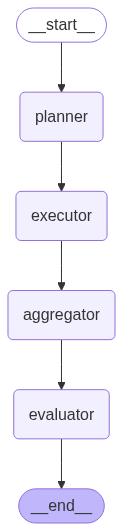

Welcome to the Advanced Multi-Agent AI Chatbot!
You can ask about weather, fashion trends, or any general query.
Type 'exit' to quit.


2025-05-25 12:30:02,008 - INFO - Planner node: determined tasks: ['generic']
2025-05-25 12:30:02,011 - INFO - Executor node: responses: {}
2025-05-25 12:30:02,018 - INFO - Aggregator node: aggregated response: 
2025-05-25 12:30:02,018 - INFO - Evaluator node: aggregated response is insufficient; invoking generic fallback.
2025-05-25 12:30:02,070 - INFO - Evaluator node: final response: [Gemini LLM]: model='models/gemini-2.0-flash' google_api_key=SecretStr('**********') temperature=0.0 max_retries=2 client=<google.ai.generativelanguage_v1beta.services.generative_service.client.GenerativeServiceClient object at 0x10bb6f470> default_metadata=() model_kwargs={}


Chatbot: No response generated.
Chatbot: Goodbye!


In [ ]:
import logging
import re
import requests
from langgraph.graph import StateGraph, MessagesState, START, END
from langchain_google_genai import ChatGoogleGenerativeAI
from IPython.display import Image, display
import os
from dotenv import load_dotenv


# Set up basic logging for debugging.
logging.basicConfig(level=logging.INFO, format="%(asctime)s - %(levelname)s - %(message)s")

######################################
# Conversational Memory Management
######################################
conversation_memory = []

def update_memory(speaker: str, message: str):
    """
    Appends a new message (with its speaker) to our short-term conversation memory.
    """
    global conversation_memory
    conversation_memory.append({"speaker": speaker, "message": message})

######################################
# Tool / Agent Implementations
######################################

# (1) Generic Agent powered by Gemini LLM.
class ChatGemini:
    """
    Dummy Gemini LLM client.
    gemini-2.0-flash
    System prompt: "You are a helpful general agent. Provide detailed and clear responses."
    """
    def __init__(self, api_key: str):
        self.api_key = api_key  # Use for authenticating with your actual Gemini endpoint.

    def chat(self, prompt: str) -> str:
        # make an API call here.
        prompt = ChatGoogleGenerativeAI(
        model="gemini-2.0-flash",
        temperature=0,
        max_tokens=None,
        timeout=None,
        max_retries=2,
        google_api_key=os.getenv("GEMINI_API_KEY"),)

        return f"[Gemini LLM]: {prompt}"

class GeminiTool:
    def __init__(self, api_key: str):
        self.gemini = ChatGemini(api_key)
        self.system_prompt = "System: You are a helpful general agent. Provide detailed and clear responses."
    
    def run(self, query: str) -> str:
        full_prompt = f"{self.system_prompt}\nUser query: {query}"
        try:
            return self.gemini.chat(full_prompt)
        except Exception as e:
            logging.error("GeminiTool error: %s", e)
            return "Generic agent encountered an error."

# (2) Weather Agent that uses the OpenWeatherMap API.
class WeatherTool:
    """
    A tool that fetches real-time weather data from the OpenWeatherMap API.
    
    System prompt: "You are a precise weather expert."
    """
    def __init__(self, api_key: str):
        self.api_key = api_key
        self.system_prompt = "System: You are a precise weather expert."

    def run(self, query: str) -> str:
        location = self.extract_location(query)
        if not location:
            return "Please specify a location to get the weather information."
        
        base_url = "http://api.openweathermap.org/data/2.5/weather"
        params = {"q": location, "appid": self.api_key, "units": "metric"}
        try:
            response = requests.get(base_url, params=params, timeout=10)
            response.raise_for_status()
            data = response.json()
            description = data["weather"][0]["description"]
            temp = data["main"]["temp"]
            return f"{self.system_prompt}\nWeather in {location}: {description} with a temperature of {temp}°C."
        except Exception as e:
            logging.error("WeatherTool error for %s: %s", location, e)
            return f"Error fetching weather for {location}."
    
    def extract_location(self, query: str) -> str:
        match = re.search(r"in\s+([A-Za-z\s]+)", query, re.IGNORECASE)
        if match:
            return match.group(1).strip()
        words = query.split()
        return words[-1] if words else None

# (3) Fashion Agent that simulates providing current fashion trends.
class FashionTool:
    """
    A tool to simulate returning current fashion trends.
    
    System prompt: "You are a leading fashion consultant providing up-to-date insights."
    """
    def __init__(self, api_key: str):
        self.api_key = api_key  # Not used in simulation; for production, integrate your API.
        self.system_prompt = "System: You are a leading fashion consultant."
    
    def run(self, query: str) -> str:
        # In a production system, integrate with a real fashion API.
        return f"{self.system_prompt}\nFashion trends: Minimalistic designs, sustainable materials, and bold colors."

######################################
# Instantiate Tools with API Keys
######################################
# Replace the following strings with your actual API keys.


load_dotenv()

WEATHER_API_KEY = os.getenv("WEATHER_API_KEY")
GEMINI_API_KEY  = os.getenv("GEMINI_API_KEY")
FASHION_API_KEY = os.getenv("FASHION_API_KEY")

weather_tool = WeatherTool(api_key=WEATHER_API_KEY)
gemini_tool  = GeminiTool(api_key=GEMINI_API_KEY)
fashion_tool = FashionTool(api_key=FASHION_API_KEY)

# Create a tool registry to map domain identifiers to their respective tools.
tools_registry = {
    "weather": weather_tool,
    "fashion": fashion_tool,
    "generic": gemini_tool
}

######################################
# Multi-Agent Nodes for LangGraph
######################################

# (A) Planner Node: Analyze the query and plan which domain(s) to invoke.
def planner_node(state: MessagesState) -> MessagesState:
    query = state.get("query", "")
    tasks = []
    q_lower = query.lower()
    if "weather" in q_lower or "temp" in q_lower or "forecast" in q_lower:
        tasks.append("weather")
    if "fashion" in q_lower or "style" in q_lower or "trend" in q_lower:
        tasks.append("fashion")
    # If no domain-specific keyword is present, default to generic.
    if not tasks:
        tasks.append("generic")
    state["tasks"] = tasks
    logging.info("Planner node: determined tasks: %s", tasks)
    return state

# (B) Executor Node: Iterate over each planned task and call the appropriate tool.
def executor_node(state: MessagesState) -> MessagesState:
    tasks = state.get("tasks", [])
    responses = {}
    query = state.get("query", "")
    for task in tasks:
        tool = tools_registry.get(task, tools_registry["generic"])
        try:
            responses[task] = tool.run(query)
        except Exception as e:
            logging.error("Error executing task '%s': %s", task, e)
            responses[task] = f"Error executing {task} task."
    state["responses"] = responses
    logging.info("Executor node: responses: %s", responses)
    return state

# (C) Aggregator Node: Merge responses from all domain agents into a unified answer.
def aggregator_node(state: MessagesState) -> MessagesState:
    responses = state.get("responses", {})
    aggregated = ""
    for key, resp in responses.items():
        aggregated += f"[{key.upper()}]: {resp}\n"
    state["aggregated_response"] = aggregated.strip()
    logging.info("Aggregator node: aggregated response: %s", state["aggregated_response"])
    return state

# (D) Evaluator Node: Check aggregated response quality and, if insufficient, fallback on the generic agent.
def evaluator_node(state: MessagesState) -> MessagesState:
    aggregated = state.get("aggregated_response", "")
    # Simple evaluation: if the response is too short or contains error indicators.
    if (len(aggregated) < 50 or "error" in aggregated.lower()) and not state.get("retry"):
        state["retry"] = True  # Ensure we don't loop indefinitely.
        improved_query = f"Improve and elaborate on the following answer: {aggregated}\nOriginal query: {state.get('query', '')}"
        logging.info("Evaluator node: aggregated response is insufficient; invoking generic fallback.")
        fallback = tools_registry["generic"].run(improved_query)
        state["final_response"] = fallback
    else:
        state["final_response"] = aggregated
    logging.info("Evaluator node: final response: %s", state["final_response"])
    return state

######################################
# Build and Compile the LangGraph Workflow
######################################
graph = StateGraph(MessagesState)
graph.add_node("planner", planner_node)
graph.add_node("executor", executor_node)
graph.add_node("aggregator", aggregator_node)
graph.add_node("evaluator", evaluator_node)

# Define the workflow: START -> planner -> executor -> aggregator -> evaluator -> END
graph.add_edge(START, "planner")
graph.add_edge("planner", "executor")
graph.add_edge("executor", "aggregator")
graph.add_edge("aggregator", "evaluator")
graph.add_edge("evaluator", END)

# Compile the graph.
compiled_graph = graph.compile()


try:
    display(Image(compiled_graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass
######################################
# Chat Loop: Invoking the Graph with Conversational Memory
######################################
def chat():
    print("Welcome to the Advanced Multi-Agent AI Chatbot!")
    print("You can ask about weather, fashion trends, or any general query.")
    print("Type 'exit' to quit.")
    
    while True:
        user_input = input("You: ").strip()
        if user_input.lower() in {"exit", "quit"}:
            print("Chatbot: Goodbye!")
            break
        
        update_memory("user", user_input)
        state = {"query": user_input, "memory": conversation_memory}
        
        try:
            # Use the compiled graph's invoke() method to process the state.
            final_state = compiled_graph.invoke(state)
            final_response = final_state.get("response")
        except Exception as e:
            logging.error("Graph execution error: %s", e)
            final_response = "An error occurred while processing your query."
        
        update_memory("bot", final_response)
        print("Chatbot:", final_response)

if __name__ == "__main__":
    chat()
